## Generative Adversarial Network

Generative Adversarial Networks a.k.a GANs, are popular generative neural networks. GANs have demonstrated their effectiveness in nearly every problem in computer vision. The GAN works by training a pair of networks, Generator and Discriminator, with competing loss terms. As an analogy, we can think of these networks as an art-forger and the other, an art-expert. In GAN literature the Generator is the art-forger and the Discriminator is the art-expert. The Generator is trained to produce fake images (forgeries) to deceive the art-expert (Discriminator). The Discriminator which receives both the real images and fake images tries to distinguish between them to identify the fake images. The Generator uses the feedback from the Discriminator to improve it generation. Both the models are trained simulataneously and are always in competition with each other. This competition between the Generator and Discriminator drives them to improve their respective models continuously. The  model converges when the Generator produces fake images that are indistinguishable from the real images.  <br>

In this setup, the Generator does not have access to the real images whereas the Discriminator has access to both the real and the generated fake images. 

Let us define Discriminator D that takes an image as input and produces a number **(0/1)** as output and a Generator G that takes random noise as input and outputs a fake image. In practice, G and D are trained alternately i.e., For a fixed generator G, the Discriminator D is trained to classify the training data as real (output a value close to 1) or fake(output a value close to 0). Subsequenty, we freeze the Discriminator and train the Generator G to produce an image (fake) that outputs a value close to 1 (real) when passed through the Discriminator D. Thus, if the Generator is perfectly trained then the Discriminator D will be maximally confused by the images generated by G and predict 0.5 for all the inputs. 

**It will be ideal to solve this assignemnet on a computer with a GPU**. The Coursera platform does not support a GPU. You may want to explore [Google Colab](https://www.youtube.com/watch?v=inN8seMm7UI&ab_channel=TensorFlow) or [Kaggle](https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu)

Along with submitting the Python notebook, save the notebook along with its output after executing all the cells as a .html file and submit the html file as well. 

In this assignment, we will implement a Generative Adversarial Network on MNIST data and generate images that resemble the digits from the MNIST dataset.

To implement a GAN, we basically require 5 components:

- Real Dataset (real distribution)
- Low dimensional random noise that is input to the Generator to produce fake images
- Generator that generates fake images
- Discriminator that acts as an expert to distinguish real and fake images.
- Training loop where the competition occurs and models better themselves.


Let us implement each of the parts and train the overall model:

In [ ]:
## import packages
import torch
import random
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import os
import numpy.testing as npt
#from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Checks for the availability of GPU 
is_cuda = torch.cuda.is_available()
#is_cuda = False
if is_cuda:
    print("working on gpu!")
else:
    print("No gpu! only cpu ;)")
    
## The following random seeds are just for deterministic behaviour of the code and evaluation

##############################################################################
################### DO NOT MODIFY THE CODE BELOW #############################    
##############################################################################

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = '0'

############################################################################### 

working on gpu!


### Download Data and Setup DataLoader

In this step we work on preparing the data. We normalize the images to range [-1, +1] 

In [ ]:
import torchvision
import torchvision.transforms as transforms
import os

root = './data/'
if not os.path.isdir(root):
    os.mkdir(root)

train_bs = 128

# Data transformation for the DataLoader - normalizes to between [-1,1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])

training_data = torchvision.datasets.MNIST(root, train=True, transform=transform,download=True)
train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=train_bs, shuffle=True, drop_last=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Noise Input for the Generator 

Let us define a function which takes (batchsize, dimension) as input and returns a random noise of requested dimensions. This noise tensor will be the input to the generator.

In [ ]:
def noise(bs, dim):
    """Generate random Gaussian noise vectors N(0,I), with mean 0 and variance 1.
    
    Inputs:
    - bs: integer giving the batch size of noise to generate.
    - dim: integer giving the dimension of the Gaussain noise to generate.
    
    Returns:
    A PyTorch Tensor containing Gaussian noise with shape [bs, dim]
    """
    
    out = (torch.randn((bs, dim)))
    if is_cuda:
        out = out.cuda()
    return out

### Generator Architecture - 20 points

Define a Generator with the following architecture. 

- Linear layer (noise_dim -> 256)
- LeakyReLU (works well for the Generators, we will use negative_slope=2)
- Linear Layer (256 -> 512)
- LeakyReLU
- Linear Layer (512 -> 1024)
- LeakyReLU
- Linear Layer (1024 -> 784) (784 is the MNIST image size 28*28)
- TanH (To scale the generated images to [-1,1], the same as real images)

- LeakyRELU: https://pytorch.org/docs/stable/nn.html#leakyrelu 
- Fully connected layer: https://pytorch.org/docs/stable/nn.html#linear 
- TanH activation: https://pytorch.org/docs/stable/nn.html#tanh

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_size=784):
        super(Generator, self).__init__()
        
        '''
        REST OF THE MODEL HERE
        
        # define a fully connected layer (self.layer1) from noise_dim -> 256 neurons      
        # define a leaky relu layer(self.leaky_relu) with negative slope=0.2. We can reuse the same layer multiple times.
        # define a fully connected layer (self.layer2) from 256 -> 512 neurons
        # define a fully connected layer (self.layer3) from 512 -> 1024 neurons
        # define a fully connected layer (self.layer4) from 1024 -> out_size neurons
        # define a tanh activation function (self.tanh)
        
        '''
        # your code here
        self.layer1 = nn.Linear(noise_dim, 256)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.layer2 = nn.Linear(256, 512)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
        self.layer3 = nn.Linear(512,1024)
        self.leaky_relu3 = nn.LeakyReLU(0.2)
        self.layer4 = nn.Linear(1024, out_size)
        self.tanh = nn.Tanh()
        
        
        
        
    def forward(self, x):
        '''
        Make a forward pass of the input through the generator. Leaky relu is used as the activation 
        function in all the intermediate layers. Tanh activation function is only used at the end (which
        is after self.layer4)
        
        Note that, generator takes an random noise as input and gives out fake "images". Hence, the Tensor 
        output after tanh activation function should be reshaped into the same size as the real images. i.e., 
        [batch_size, n_channels, H, W] == (batch_size, 1,28,28). You may use the .view(.) function to acheive it.
         
        '''
        # your code here
        x = self.layer1(x)
        x = self.leaky_relu(x)
        x = self.layer2(x)
        x = self.leaky_relu2(x)
        x = self.layer3(x)
        x = self.leaky_relu3(x)
        x = self.layer4(x)
        x = self.tanh(x)
        x = x.view(x.shape[0], 1, 28, 28)
        
        return x
             

In [ ]:
# Initialize the Generator and move it to GPU (if is_cuda)
generator = Generator()
print(generator)
# If you have a system with a GPU, you may want to install torchsummary and display the network in more detail 
# summary(generator,(100,), device='cpu')

# move to GPU
if is_cuda:
    generator = generator.cuda()

Generator(
  (layer1): Linear(in_features=100, out_features=256, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (layer2): Linear(in_features=256, out_features=512, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (layer3): Linear(in_features=512, out_features=1024, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (layer4): Linear(in_features=1024, out_features=784, bias=True)
  (tanh): Tanh()
)


In [ ]:
# Test cases
# Note the testcases only tests for input and output dimensions and range of values. 
# You may modify the architecture within those constraints
# noise_dim is always 100
# Input to generator is (B,noise_dim) where B is arbitray batch_size
# Output of the Generator is (B,1,28,28) where B is arbitray batch_size, 1 is the grayscale channel 28 is image size 
# The Generator Output is between [-1,1] since we use tanh() activations. 
# Input to Discriminator is (B,1,28,28), where B is arbitray batch_size, 1 is the grayscale channel 28 is image size
# output of the discriminator is Tensor of dimension (B,1) where B is arbitray batch_size 

a = torch.ones(5,100)
if is_cuda:
    a = a.cuda()
out = generator(a)
npt.assert_equal(out.shape, (5,1,28,28))
assert np.max(out.detach().cpu().numpy()) <= 1
assert np.min(out.detach().cpu().numpy()) >= -1

# Hidden test cases follow

In [ ]:
# Hidden test cases follow
# HIDDEN TESTS
a = torch.ones(10,100)
if is_cuda:
    a = a.cuda()
out = generator(a)
npt.assert_equal(out.shape, (10,1,28,28))
assert np.max(out.detach().cpu().numpy()) <= 1
assert np.min(out.detach().cpu().numpy()) >= -1
# HIDDEN TESTS

### Discriminator Architecture - 20 points

Define a Discriminator with the following architecture. 

- Linear Layer (input_size -> 512)
- LeakyReLU with negative slope = 0.2
- Linear Layer (512 -> 256)
- LeakyReLU with negative slope = 0.2
- Linear Layer (256 -> 1)

In [ ]:
## Similar to the Generator, we now define a Discriminator which takes in a vector and output a single scalar 
## value. 

class Discriminator(nn.Module):
    def __init__(self, input_size=784):
        super(Discriminator, self).__init__()
        '''
        REST OF THE MODEL HERE
        
        # define a fully connected layer (self.layer1) from input_size -> 512 neurons   
        # define a leaky relu layer(self.leaky_relu) with negative slope=0.2. (we will reuse the same layer)
        # define a fully connected layer (self.layer2) from 512 -> 256 neurons
        # define a fully connected layer (self.layer3) from 256 -> 1 neurons
        '''
        # your code here
        self.layer1 = nn.Linear(input_size, 512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.layer2 = nn.Linear(512,256)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
        self.layer3 = nn.Linear(256, 1)
        
    
    def forward(self, x):
        '''
        The Discriminator takes a vectorized input of the real and generated fake images. Reshape the input 
        to match the Discriminator architecture. 
        
        Make a forward pass of the input through the Discriminator and return the scalar output of the 
        Discriminator.
        '''
        # your code here
        x = x.view(x.shape[0], 784)
        x = self.layer1(x)
        x = self.leaky_relu(x)
        x = self.layer2(x)
        x = self.leaky_relu2(x)
        x = self.layer3(x)

        
        
        return x      
        

In [ ]:
# Initialize the Discriminator and move it to GPU (if is_cuda)
discriminator = Discriminator()

print(discriminator)
# If you have a system with a GPU, you may want to install torchsummary and display the network in more detail 
# summary(discriminator,(784,), device='cpu')

# move to GPU
if is_cuda:
    discriminator = discriminator.cuda()

Discriminator(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (layer3): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
# Test cases
# Note the testcases only tests for input and output dimensions and range of values. 
# You may modify the architecture within those constraints
# noise_dim is always 100
# Input to generator is (B,noise_dim) where B is arbitray batch_size
# Output of the Generator is (B,1,28,28) where B is arbitray batch_size, 1 is the grayscale channel 28 is image size 
# The Generator Output is between [-1,1] since we use tanh() activations. 
# Input to Discriminator is (B,1,28,28), where B is arbitray batch_size, 1 is the grayscale channel 28 is image size
# output of the discriminator is Tensor of dimension (B,1) where B is arbitray batch_size 

a = torch.ones(5,1,28,28)
if is_cuda:
    a = a.cuda()
out = discriminator(a)
npt.assert_equal(out.shape, (5,1))

# Hidden testcases follow

In [ ]:
# HIDDEN TESTS
a = torch.rand(5,1,28,28)
if is_cuda:
    a = a.cuda()
out = discriminator(a)
npt.assert_equal(out.shape, (5,1))
# HIDDEN TESTS

### Binary Cross Entropy Loss 

We will use the Binary cross entropy loss function to train the GAN. The loss function includes sigmoid activation followed by logistic loss. This allows us to distinguish between real and fake images.

Binary cross entropy loss with logits: https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss

In [ ]:
# Initialize the 'BCEWithLogitsLoss' object
bce_loss = nn.BCEWithLogitsLoss()

### Discriminator Loss  - 10 points

Let's define the objective function for the Discriminator. It takes as input the logits (outputs of the Discriminator) and the labels (real or fake). It uses the BCEWithLogitsLoss() to compute the loss in classification.

In [ ]:
def DLoss(logits_real, logits_fake, targets_real, targets_fake):
    '''
    Returns the Binary Cross Entropy Loss between predictions and targets
    
    Inputs:
        logits_real: the outputs of the discriminator (before the sigmoid) for real images
        logits_fake: the outputs of the discriminator (before the sigmoid) for fake images
        targets_real: groundtruth labels for real images
        targets_fake: groundtruth labels for fake images
    
    '''
    # Concatenate the logits_real and the logits_fake using torch.cat() to get 'logits'
    logits = torch.cat((logits_real, logits_fake), 1)
    # Concatenate the targets_real and the targets_fake using torch.cat() to get 'targets'
    targets = torch.cat((targets_real, targets_fake),1)
    # estimate the loss using the BCEWithLogitsLoss object 'bce' with 'logits' and 'targets'
    loss = bce_loss(logits, targets)
    # your code here
    
    return loss

In [ ]:
# Hidden testcases follow

In [ ]:
# HIDDEN TESTS
logits_real = torch.tensor([[ 1.1879,  1.4300, -1.9745,  0.3595, -0.3477,  0.5334,  0.0642, -0.2792]])
logits_fake = torch.tensor([[-0.6240,  1.9102, -0.2699,  0.6910, -1.0568, -1.1010, -0.9387,  1.5075]])

targets_real = torch.ones(1,8)
targets_fake = torch.zeros(1,8)

d_loss = DLoss(logits_real, logits_fake, targets_real, targets_fake)
npt.assert_almost_equal(d_loss.item(), 0.7954437732696533,decimal=5)

# HIDDEN TESTS

### Generator Loss  - 10 points

Let's define the objective function for the Generator. It takes as input the logits (outputs of the Discriminator) for the fake images it has generated and the labels (real). It uses the BCEWithLogitsLoss() to compute the loss in classification. 
The Generator expects the logits for the fake images it has generated to be close to 1 (real). If that is not the case, the Generatro corrects itself with the loss

In [ ]:
def GLoss(logits_fake, targets_real):
    '''
    The aim of the Generator is to fool the Discriminator into "thinking" the generated images are real.
    GLoss is the binary cross entropy loss between the outputs of the Discriminator with the 
    generated fake images 'logits_fake' and real targets 'targets_real'
    
    Inputs: 
        logits_fake: Logits from the Discriminator for the fake images generated by the Generator
        targets_real: groundtruth labels (close to 1) for the logits_fake
    '''
    # estimate the g_loss using the BCEWithLogitsLoss object 'bce' with 'logits_fake' and 'targets_real'
    # your code here
    g_loss = bce_loss(logits_fake, targets_real)
    
    return g_loss

In [ ]:
# Hidden testcases follow

In [ ]:
# HIDDEN TESTS
logits_fake = torch.tensor([[-0.6240,  1.9102, -0.2699,  0.6910, -1.0568, -1.1010, -0.9387,  1.5075]])
targets_real = torch.ones(1,8)
g_loss = GLoss(logits_fake, targets_real)
npt.assert_almost_equal(g_loss.item(), 0.8308159708976746,decimal=5)

# HIDDEN TESTS

### GAN Training - 40 points

Optimizers for training the Generator and the Discriminator. The below setup generates good images with the architecture. 
Feel free to adjust the optimizer settings. 

Adam optimizer: https://pytorch.org/docs/stable/optim.html#torch.optim.Adam

In [ ]:
#The following settings generated realistic images. Feel free to adjust the settings.
epochs = 40
noise_dim = 100
LR = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

Epoch:   0
D Loss:  0.5142484307289124
G Loss:  1.4877581596374512


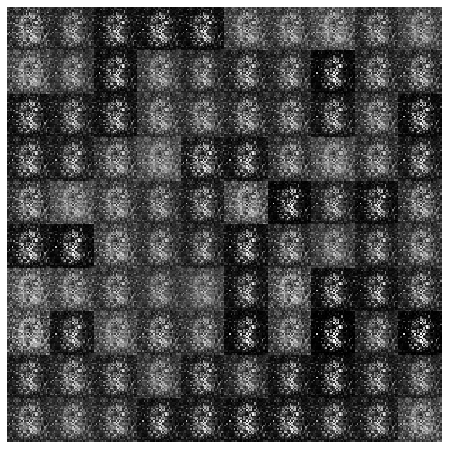

Epoch:   1
D Loss:  0.5560953617095947
G Loss:  1.166382074356079
Epoch:   2
D Loss:  0.5644389390945435
G Loss:  1.2125561237335205


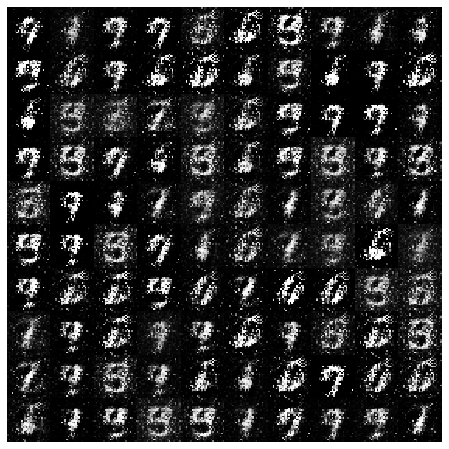

Epoch:   3
D Loss:  0.4975994825363159
G Loss:  1.3018832206726074
Epoch:   4
D Loss:  0.49432048201560974
G Loss:  1.1209659576416016


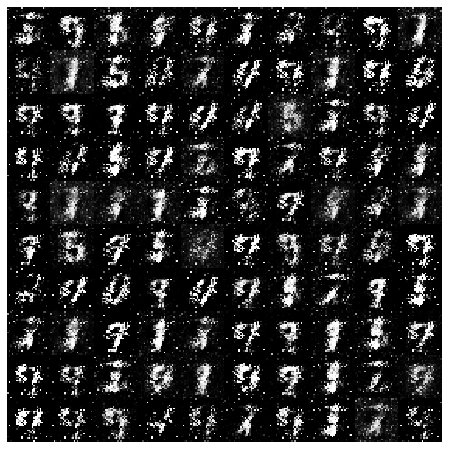

Epoch:   5
D Loss:  0.6089316606521606
G Loss:  2.5566940307617188
Epoch:   6
D Loss:  0.6867313385009766
G Loss:  2.468543767929077


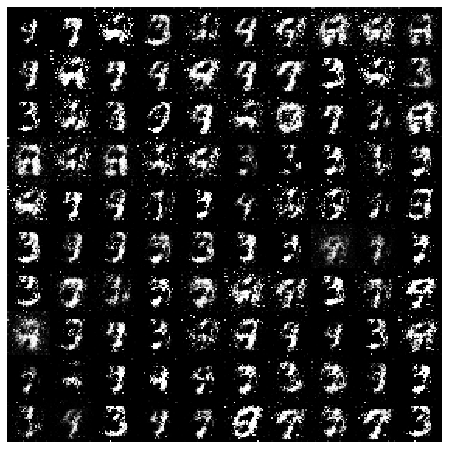

Epoch:   7
D Loss:  0.5477378368377686
G Loss:  1.143420696258545
Epoch:   8
D Loss:  0.522401750087738
G Loss:  1.0268840789794922


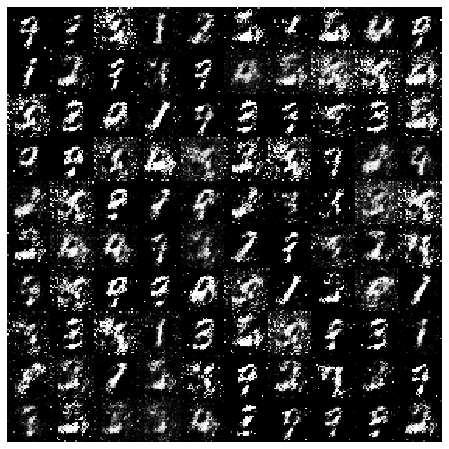

Epoch:   9
D Loss:  0.70482337474823
G Loss:  1.5465153455734253
Epoch:   10
D Loss:  0.5558896660804749
G Loss:  1.3293242454528809


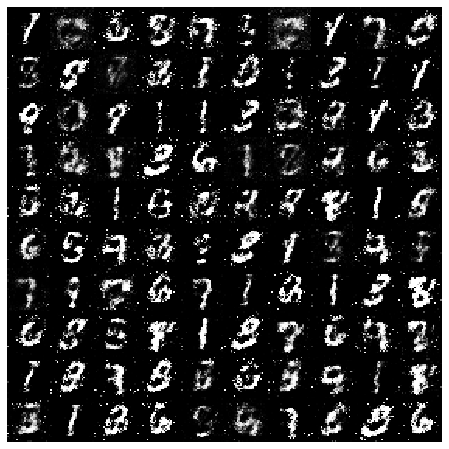

Epoch:   11
D Loss:  0.6134342551231384
G Loss:  0.7600762844085693
Epoch:   12
D Loss:  0.6207008957862854
G Loss:  1.3037223815917969


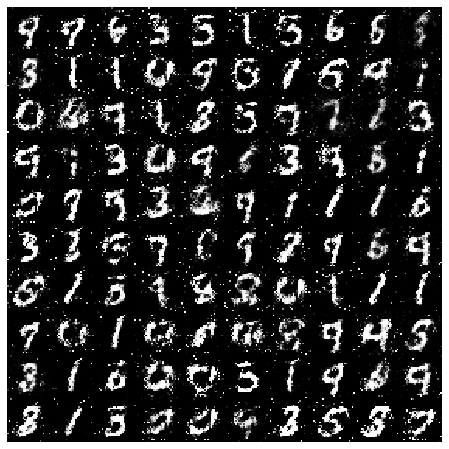

Epoch:   13
D Loss:  0.5805158615112305
G Loss:  0.9649211168289185
Epoch:   14
D Loss:  0.5893878936767578
G Loss:  1.010843276977539


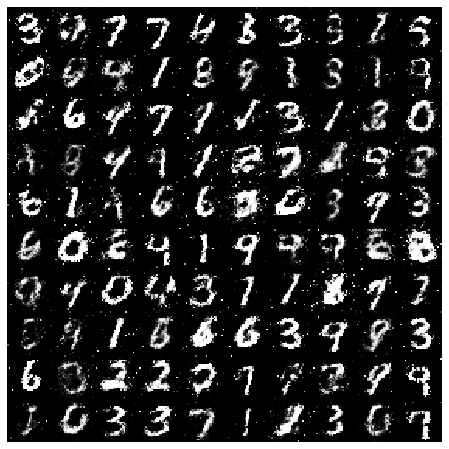

Epoch:   15
D Loss:  0.7334326505661011
G Loss:  0.4938284754753113
Epoch:   16
D Loss:  0.6664155721664429
G Loss:  1.3780937194824219


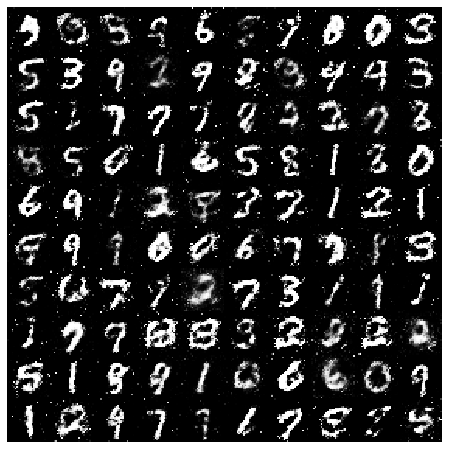

Epoch:   17
D Loss:  0.6131110787391663
G Loss:  0.9235090017318726
Epoch:   18
D Loss:  0.6042958498001099
G Loss:  0.996713399887085


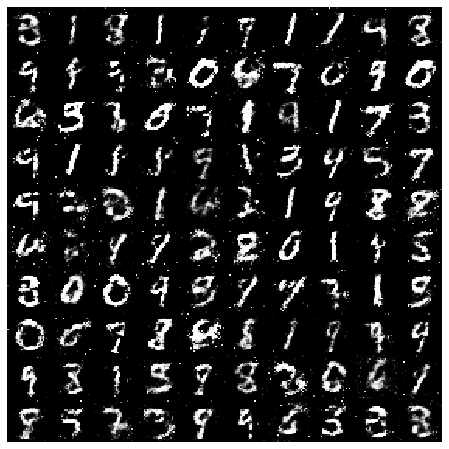

Epoch:   19
D Loss:  0.6168619990348816
G Loss:  0.9432961344718933
Epoch:   20
D Loss:  0.6463958024978638
G Loss:  0.6443821787834167


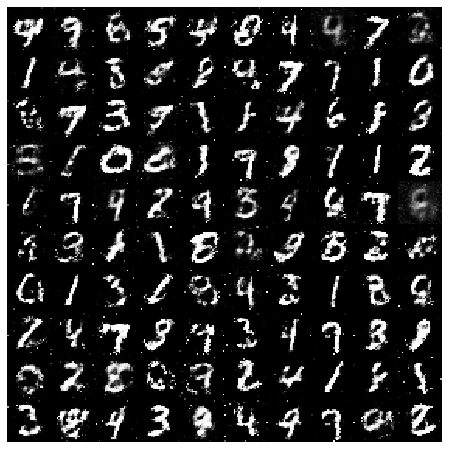

Epoch:   21
D Loss:  0.6406599879264832
G Loss:  0.7347133159637451
Epoch:   22
D Loss:  0.6504789590835571
G Loss:  0.7473773956298828


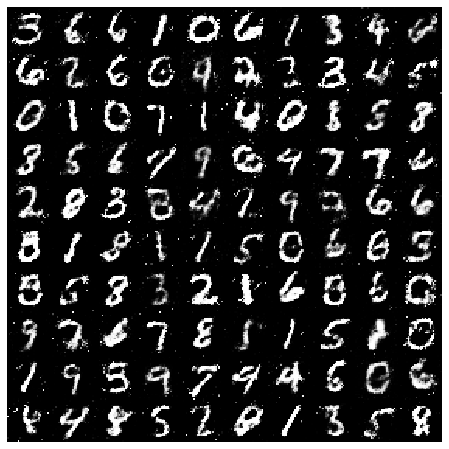

Epoch:   23
D Loss:  0.6114305257797241
G Loss:  0.8936630487442017
Epoch:   24
D Loss:  0.6280303001403809
G Loss:  0.920103907585144


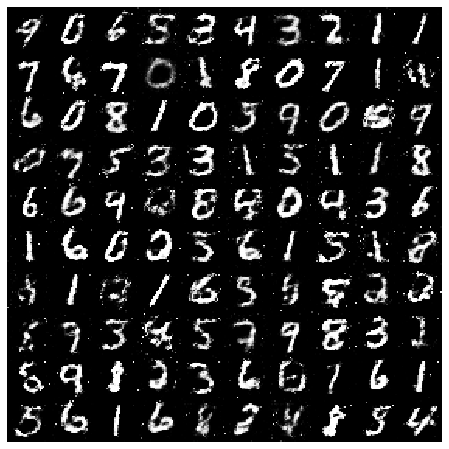

Epoch:   25
D Loss:  0.6487562656402588
G Loss:  1.0748491287231445
Epoch:   26
D Loss:  0.6231887936592102
G Loss:  0.7768195867538452


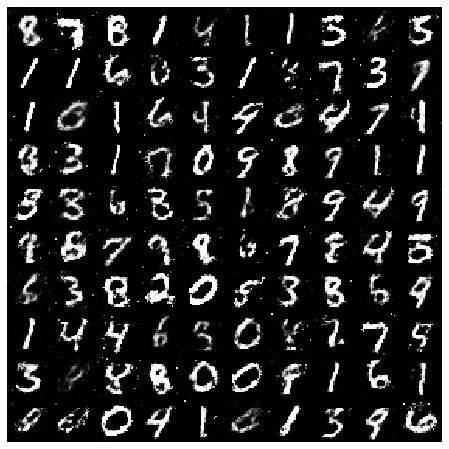

Epoch:   27
D Loss:  0.6038528680801392
G Loss:  0.9797443747520447
Epoch:   28
D Loss:  0.623391330242157
G Loss:  0.7344170808792114


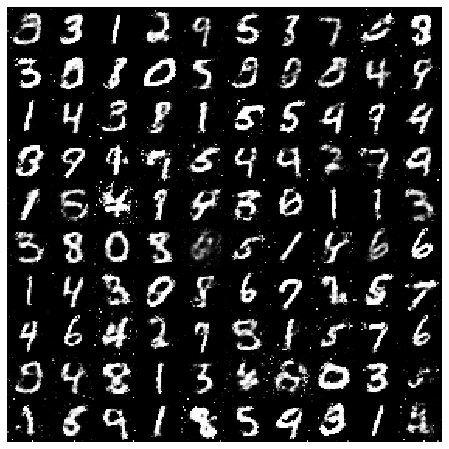

Epoch:   29
D Loss:  0.6325916051864624
G Loss:  1.0152943134307861
Epoch:   30
D Loss:  0.6249176859855652
G Loss:  0.8573834300041199


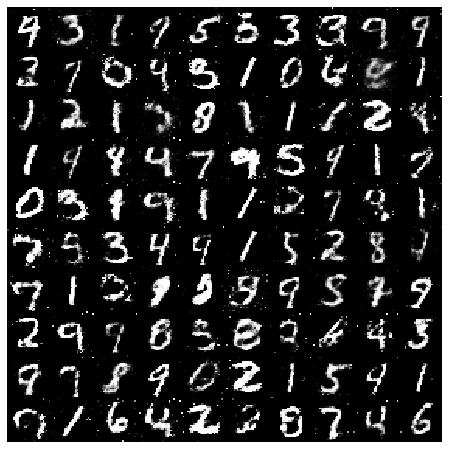

Epoch:   31
D Loss:  0.6322046518325806
G Loss:  0.786340594291687
Epoch:   32
D Loss:  0.6199404001235962
G Loss:  0.7270089387893677


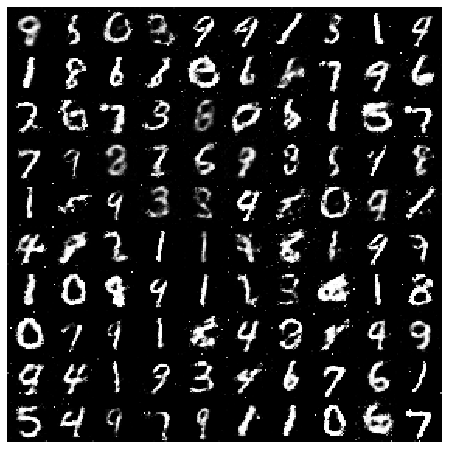

Epoch:   33
D Loss:  0.6352604627609253
G Loss:  0.6843974590301514
Epoch:   34
D Loss:  0.6158955693244934
G Loss:  0.9054239988327026


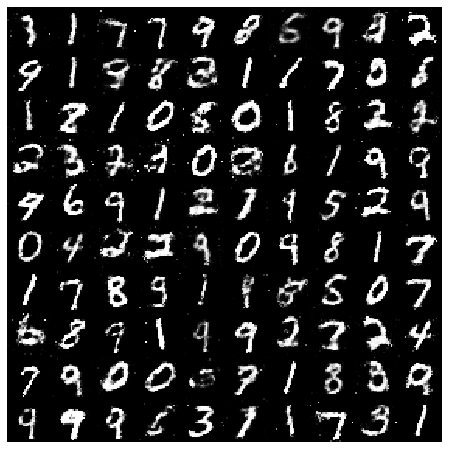

Epoch:   35
D Loss:  0.6140469908714294
G Loss:  0.7487614750862122
Epoch:   36
D Loss:  0.6432754993438721
G Loss:  1.2725229263305664


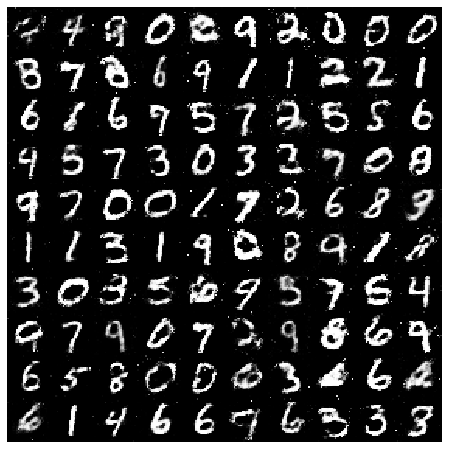

Epoch:   37
D Loss:  0.6275341510772705
G Loss:  0.745873212814331
Epoch:   38
D Loss:  0.6284674406051636
G Loss:  1.040954351425171


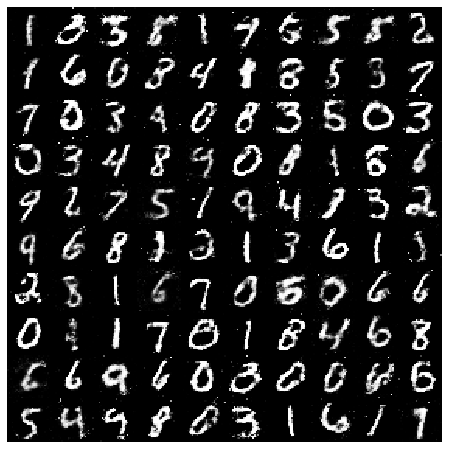

Epoch:   39
D Loss:  0.6015980243682861
G Loss:  0.8776243925094604


In [ ]:
## Training loop

for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        
        # We set targets_real and targets_fake to non-binary values(soft and noisy labels).
        # This is a hack for stable training of GAN's.  
        # GAN hacks: https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
        
        targets_real = (torch.FloatTensor(images.size(0), 1).uniform_(0.8, 1.0))
        targets_fake = (torch.FloatTensor(images.size(0), 1).uniform_(0.0, 0.2))
                
        if is_cuda:
            targets_real = targets_real.cuda()
            targets_fake = targets_fake.cuda()
            images = images.cuda()
        
        ## D-STEP:
        ## First, clear the gradients of the Discriminator optimizer.
        optimizer_D.zero_grad()
        ## Estimate logits_real by passing images through the Discriminator
        logits_real = discriminator(images)
        ## Generate fake_images by passing random noise through the Generator. Also, .detach() the fake images 
          ## as we don't compute the gradients of the Generator when optimizing Discriminator.
          ## fake_images = generator(noise(train_bs, noise_dim)).detach()
        fake_images = generator(noise(train_bs, noise_dim)).detach()
        ## Estimate logits_fake by passing the fake images through the Discriminator
        logits_fake = discriminator(fake_images)
        ## Compute the Discriminator loss by calling DLoss function.
        discriminator_loss = DLoss(logits_real, logits_fake, targets_real, targets_fake)
        ## Compute the gradients by backpropagating through the computational graph.
        discriminator_loss.backward()
        ## Update the Discriminator parameters.
        optimizer_D.step()
        
        
        ## G-STEP:
        ## clear the gradients of the Generator.
        optimizer_G.zero_grad() 
        ## Generate fake images by passing random noise through the Generator. 
        fake_images = generator(noise(train_bs, noise_dim))
        ## Estimate logits_fake by passing the fake images through the Discriminator.
        logits_fake = discriminator(fake_images)
        ## compute the Generator loss by caling GLoss.
        generator_loss = GLoss(logits_fake, targets_real)
        ## compute the gradients by backpropagating through the computational graph.
        generator_loss.backward()
        ## Update the Generator parameters. 
        optimizer_G.step()
        
        # your code here
        

    print("Epoch:  ", epoch)
    print("D Loss: ", discriminator_loss.item())
    print("G Loss: ", generator_loss.item())
          
    if epoch % 2 == 0:
        viz_batch = fake_images.data.cpu().numpy()
        viz_batch = viz_batch[:100,:,:,:]
        viz_batch = viz_batch.reshape(-1,28*28).squeeze()
        viz_batch = viz_batch.reshape(10,10, 28,28).transpose(0,2,1,3).reshape(28*10,-1)

        plt.figure(figsize = (8,8))
        plt.axis('off')
        plt.imshow(viz_batch, cmap='gray')
        plt.show()

#### The assignment is graded both manually and using auto-graded testcases.